In [1]:
import os 
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import nibabel as nb 
from nibabel import gifti
import nipype.interfaces.freesurfer as fs
from nilearn._utils.compat import _basestring
from nilearn.plotting.img_plotting  import _get_colorbar_and_data_ranges
from nilearn.plotting.surf_plotting import load_surf_data
from nilearn.plotting.surf_plotting import load_surf_mesh
from nilearn import datasets
from nilearn import plotting
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## design the colorbar

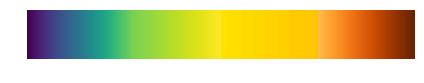

In [2]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('nipy_spectral')
new_cmap = truncate_colormap(cmap, 0.2, 0.95)

#colors1 = plt.cm.YlGnBu(np.linspace(0, 1, 128))
first = 70
second = 58
third  = 64
fourth = 64

colors1 = plt.cm.viridis(np.linspace(0., 0.80, first))
colors2 = plt.cm.viridis(np.linspace(0.8, 1, second))
colors3 = plt.cm.jet(np.linspace(0.67, 0.7, third))
colors4 = plt.cm.YlOrBr(np.linspace(0.4, 1, fourth))

cols = np.vstack((colors1,colors2, colors3, colors4))
pnasEDITED = colors.LinearSegmentedColormap.from_list('my_colormap', cols)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=pnasEDITED, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()

In [3]:
def map_to_surf(vol_file, hemi_str, out_file):
    sampler = fs.SampleToSurface(hemi=hemi_str)
    sampler.inputs.source_file     = vol_file
    sampler.inputs.mni152reg       = True
    sampler.inputs.sampling_method = "average"
    sampler.inputs.sampling_range  = (0.2, 0.8, 0.2)
    sampler.inputs.sampling_units  = "frac"
    sampler.inputs.target_subject  = 'fsaverage5'
    sampler.inputs.interp_method   = 'nearest'
    sampler.inputs.out_file        = out_file
    res = sampler.run()       
    data =  nb.load(out_file).get_data().reshape(10242,)
    return data

# plot an inflated surface brain

In [4]:
fs5 = datasets.fetch_surf_fsaverage5()

# load mesh and derive axes limits
mesh_left  = load_surf_mesh(fs5['infl_left'])
mesh_right = load_surf_mesh(fs5['infl_right'])

coords_left, faces_left   = mesh_left[0], mesh_left[1]
coords_right, faces_right = mesh_right[0], mesh_right[1]

print coords_left.shape, faces_left.shape
print coords_right.shape, faces_right.shape


(10242, 3) (20480, 3)
(10242, 3) (20480, 3)


In [5]:
def plot_surf_only(fsaverage, 
                   surf_map_l,
                   surf_map_r, 
                   alpha = 0.7):

    # load mesh and derive axes limits
    mesh_left = load_surf_mesh(fsaverage['infl_left'])
    mesh_right = load_surf_mesh(fsaverage['infl_right'])

    coords_left, faces_left = mesh_left[0], mesh_left[1]
    coords_right, faces_right = mesh_right[0], mesh_right[1]

    limits = [-124, 50]

    avg_method = 'mean'
    darkness=0.65

    def subplot(surf_map, bg_map, subplot_id, coords, 
                faces, elev, azim):

        ax = fig.add_subplot(subplot_id, projection='3d',
                             xlim=limits, ylim=limits)
        #ax.set_axis_bgcolor('white')
        ax.view_init(elev=elev, azim=azim)
        ax.set_axis_off()
        p3dcollec = ax.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2],
                                    triangles=faces, linewidth=0.,
                                    antialiased=False)

        face_colors = np.ones((faces.shape[0], 4))

        bg_data = load_surf_data(bg_map)
        if bg_data.shape[0] != coords.shape[0]:
            raise ValueError('The bg_map does not have the same number '
                             'of vertices as the mesh.')
        bg_faces = np.mean(bg_data[faces], axis=1)
        bg_faces = bg_faces - bg_faces.min()
        bg_faces = bg_faces / bg_faces.max()
        
        print bg_faces.min(), bg_faces.max(), bg_faces.mean()
        # control background darkness
        bg_faces *= darkness
        face_colors = plt.cm.gray_r(bg_faces)
        # modify alpha values of background
        face_colors[:, 3] = alpha * face_colors[:, 3]
        # should it be possible to modify alpha of surf data as well?
        p3dcollec.set_facecolors(face_colors)

    fig = plt.figure(figsize=(25,10))
    
    subplot(surf_map_l, fsaverage['sulc_left'], 121, 
            coords_left, faces_left, elev=0, azim=180)
    
    subplot(surf_map_r, fsaverage['sulc_right'], 122, 
            coords_right, faces_right, elev=0, azim=0)

    return fig

0.0 1.0 0.4554627105615337
0.0 1.0 0.45479670227204466


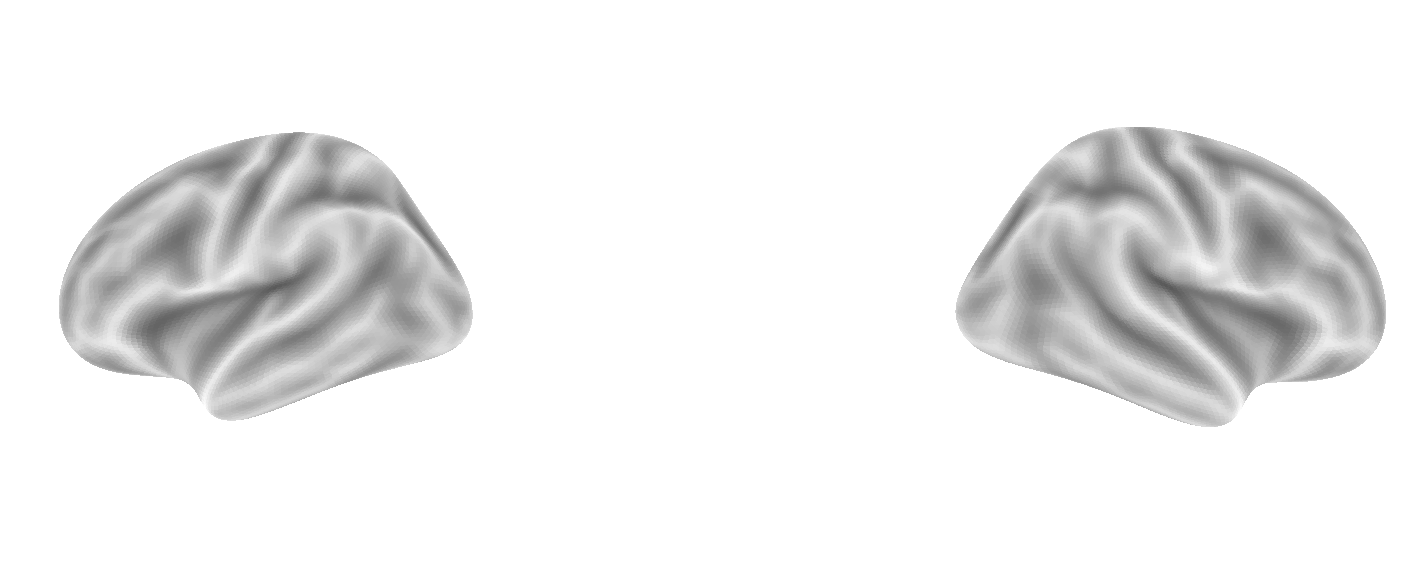

In [6]:
vol_filename = '/data/pt_mar006/components/mni3_component_1.nii.gz'

surfLH_fileout = '/data/pt_mar006/components/mni3_component_1_lh.mgz' 
surfRH_fileout = '/data/pt_mar006/components/mni3_component_1_rh.mgz'

#A_lh = map_to_surf(vol_filename, 'lh', surfLH_fileout)
#A_rh = map_to_surf(vol_filename, 'rh', surfRH_fileout)

A_lh = nb.load(surfLH_fileout).get_data().reshape(10242,)
A_rh = nb.load(surfRH_fileout).get_data().reshape(10242,)



figure = plot_surf_only(fs5, A_lh, A_rh, alpha = 1)

In [7]:
cort_lh = nb.freesurfer.io.read_label('/afs/cbs.mpg.de/software/freesurfer/6.0.0/ubuntu-xenial-amd64/subjects/fsaverage5/label/lh.cortex.label')
cort_rh = nb.freesurfer.io.read_label('/afs/cbs.mpg.de/software/freesurfer/6.0.0/ubuntu-xenial-amd64/subjects/fsaverage5/label/rh.cortex.label')

# plot gradients along the surface

In [8]:
def plot_surf_infl(fsaverage, 
                   fsize,
                   surf_map_l=None, 
                   surf_map_r=None,
                   vmin = None,
                   vmax = None,
                   threshold = None,
                   alpha = 0.7,
                   cmap = 'hot',
                   mask_lh=None,
                   mask_rh=None,):

    # load mesh and derive axes limits
    mesh_left  = load_surf_mesh(fsaverage['infl_left'])
    mesh_right = load_surf_mesh(fsaverage['infl_right'])

    coords_left, faces_left   = mesh_left[0], mesh_left[1]
    coords_right, faces_right = mesh_right[0], mesh_right[1]

    #limits =  [-150, 50]
    limits = [-124, 124]
    
    avg_method = 'mean'
    darkness   = 0.3
    
    # if no cmap is given, set to matplotlib default
    if cmap is None:
        cmap = plt.cm.get_cmap(plt.rcParamsDefault['image.cmap'])
    else:
        # if cmap is given as string, translate to matplotlib cmap
        if isinstance(cmap, _basestring):
            cmap = plt.cm.get_cmap(cmap)

    def subplot(surf_map, bg_map, subplot_id, coords, faces, 
                elev, azim, vmin = vmin, vmax = vmax,
                mask=None, mask_lenient=None):

        bg_on_data=False
        
        fig.subplots_adjust(wspace=0, hspace=0)
        
        ax = fig.add_subplot(subplot_id, projection='3d', xlim=limits, ylim=limits)
        #ax.set_axis_bgcolor('white')
        ax.view_init(elev=elev, azim=azim)
        ax.set_axis_off()
        p3dcollec = ax.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2],
                                    triangles=faces, linewidth=0.,
                                    antialiased=False, color='red')
        if mask is not None:    
            cmask = np.zeros(len(coords))
            cmask[mask] = 1
            cutoff = 2 
            if mask_lenient: 
                cutoff = 0
            fmask = np.where(cmask[faces].sum(axis=1) > cutoff)[0]

        if bg_map is not None or surf_map is not None:

            face_colors = np.ones((faces.shape[0], 4))
   
            if bg_map is not None:
                bg_data = load_surf_data(bg_map)
                if bg_data.shape[0] != coords.shape[0]:
                    raise ValueError('The bg_map does not have the same number '
                                     'of vertices as the mesh.')
                bg_faces = np.mean(bg_data[faces], axis=1)
                bg_faces = bg_faces - bg_faces.min()
                bg_faces = bg_faces / bg_faces.max()
                # control background darkness
                bg_faces *= darkness
                face_colors = plt.cm.gray_r(bg_faces)

            # modify alpha values of background
            face_colors[:, 3] = alpha * face_colors[:, 3]

            if surf_map is not None:
                surf_map_data = surf_map
                if len(surf_map_data.shape) is not 1:
                    raise ValueError('surf_map can only have one dimension but has'
                                     '%i dimensions' % len(surf_map_data.shape))
                if surf_map_data.shape[0] != coords.shape[0]:
                    raise ValueError('The surf_map does not have the same number '
                                     'of vertices as the mesh.')

                # create face values from vertex values by selected avg methods
                if avg_method   == 'mean':
                    surf_map_faces = np.mean(surf_map_data[faces], axis=1)
                elif avg_method == 'median':
                    surf_map_faces = np.median(surf_map_data[faces], axis=1)

                # if no vmin/vmax are passed figure them out from data
                if vmin is None:
                    vmin = np.nanmin(surf_map_faces)
                if vmax is None:
                    vmax = np.nanmax(surf_map_faces)

                # treshold if inidcated
                if threshold is None:
                    kept_indices = np.where(surf_map_faces)[0]
                else:
                    kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]

                surf_map_faces = surf_map_faces - vmin
                surf_map_faces = surf_map_faces / (vmax - vmin)

                # multiply data with background if indicated
                if bg_on_data:
                    face_colors[kept_indices] = cmap(surf_map_faces[kept_indices])\
                        * face_colors[kept_indices]
                else:
                    if mask is None:
                        face_colors[kept_indices] = cmap(surf_map_faces[kept_indices])
                    else:
                        face_colors[fmask] = cmap(surf_map_faces)[fmask] * face_colors[fmask]

            p3dcollec.set_facecolors(face_colors)

    fig = plt.figure(figsize=fsize)
    
    subplot(surf_map_l, fsaverage['sulc_left'], 121, coords_left,  
            faces_left, elev=0, azim=180, mask=mask_lh)

    #subplot(surf_map_l, fsaverage['sulc_left'], 142, coords_left,  
    #        faces_left, elev=0, azim=0, mask=mask_lh)

    #subplot(surf_map_r, fsaverage['sulc_right'], 143, coords_right,  
    #        faces_right, elev=0, azim=180, mask=mask_rh)
    
    subplot(surf_map_r, fsaverage['sulc_right'], 122, coords_right,  
            faces_right, elev=0, azim=0, mask=mask_rh)

    return fig

# Gradient 1

In [9]:
vol_filename = '/data/pt_mar006/components/mni3_component_1.nii.gz'

surfLH_fileout = '/data/pt_mar006/components/mni3_component_1_lh.mgz' 
surfRH_fileout = '/data/pt_mar006/components/mni3_component_1_rh.mgz'

#A_lh = map_to_surf(vol_filename, 'lh', surfLH_fileout)
#A_rh = map_to_surf(vol_filename, 'rh', surfRH_fileout)

A_lh = nb.load(surfLH_fileout).get_data().reshape(10242,)
A_rh = nb.load(surfRH_fileout).get_data().reshape(10242,)

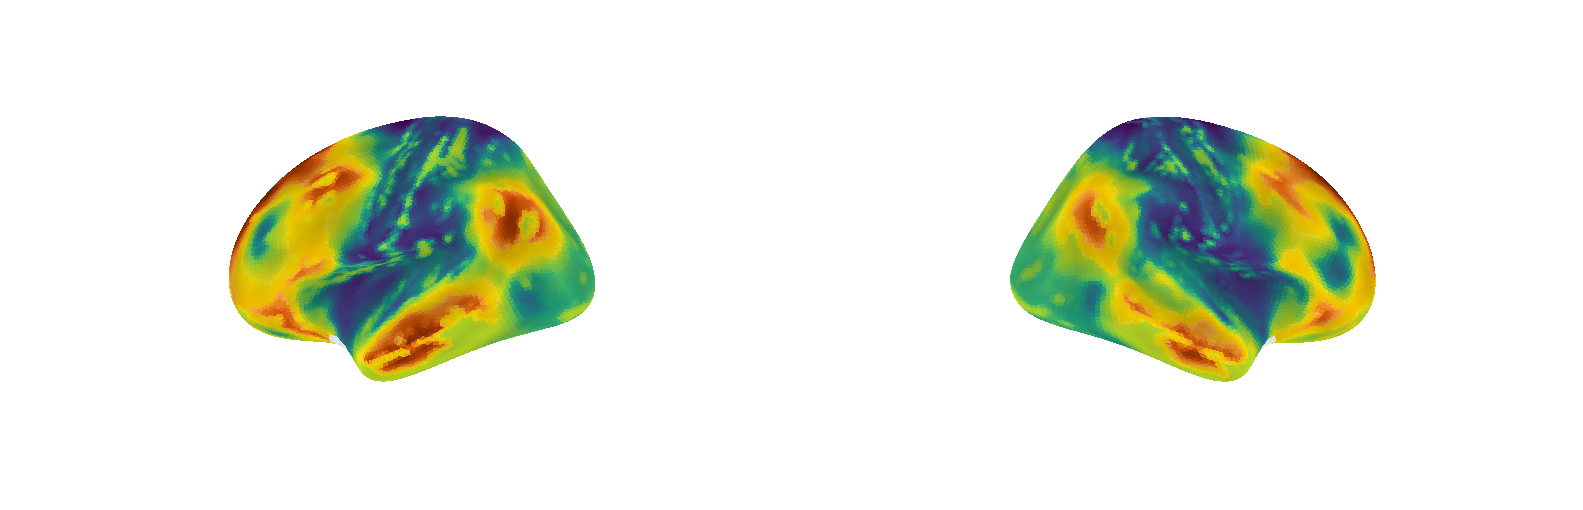

In [10]:
my_min = A_lh.min()
my_max = A_lh.max()

figure = plot_surf_infl(fs5, 
                        fsize=(28, 9),
                        surf_map_l = A_lh, 
                        surf_map_r = A_rh,
                        vmin = my_min,
                        vmax = my_max,
                        threshold = None,
                        alpha = 1.,
                        cmap = pnasEDITED,
                        mask_lh = cort_lh,
                        mask_rh = cort_rh)

# Gradient 1, five-percentiles

In [11]:
vol_filename = '/data/pt_mar006/components/mni3_component_1.nii.gz'

surfLH_fileout = '/data/pt_mar006/components/mni3_component_1_lh.mgz' 
surfRH_fileout = '/data/pt_mar006/components/mni3_component_1_rh.mgz'

#A_lh = map_to_surf(vol_filename, 'lh', surfLH_fileout)
#A_rh = map_to_surf(vol_filename, 'rh', surfRH_fileout)

A_lh = nb.load(surfLH_fileout).get_data().reshape(10242,)
A_rh = nb.load(surfRH_fileout).get_data().reshape(10242,)

X = A_lh
Y = A_rh
print X.shape, Y.shape


(10242,) (10242,)


(array([512., 512., 512., 512., 513., 512., 512., 512., 512., 512., 512.,
        512., 512., 512., 512., 512., 512., 512., 512., 513.]),
 array([ 0.  ,  0.95,  1.9 ,  2.85,  3.8 ,  4.75,  5.7 ,  6.65,  7.6 ,
         8.55,  9.5 , 10.45, 11.4 , 12.35, 13.3 , 14.25, 15.2 , 16.15,
        17.1 , 18.05, 19.  ], dtype=float32),
 <a list of 20 Patch objects>)

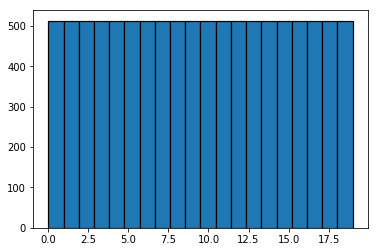

In [12]:
a     = X.copy()
b     = Y.copy()


bins         = 20
steps        = int((1/float(bins))*len(a))
# from lowest to highest
data_argsort = np.argsort(a)[::-1]
data_argsort = np.flip(data_argsort, axis=0)

data_argsort_b = np.argsort(b)[::-1]
data_argsort_b = np.flip(data_argsort_b, axis=0)


for thisp in range(bins):
    # from highest to lowest
    index = data_argsort[thisp*steps :(thisp+1)*steps+1] 
    a[index] = thisp
    
    index_b = data_argsort_b[thisp*steps :(thisp+1)*steps+1]
    b[index_b] = thisp    

plt.hist(b, bins=20,edgecolor='black', linewidth=1.2)

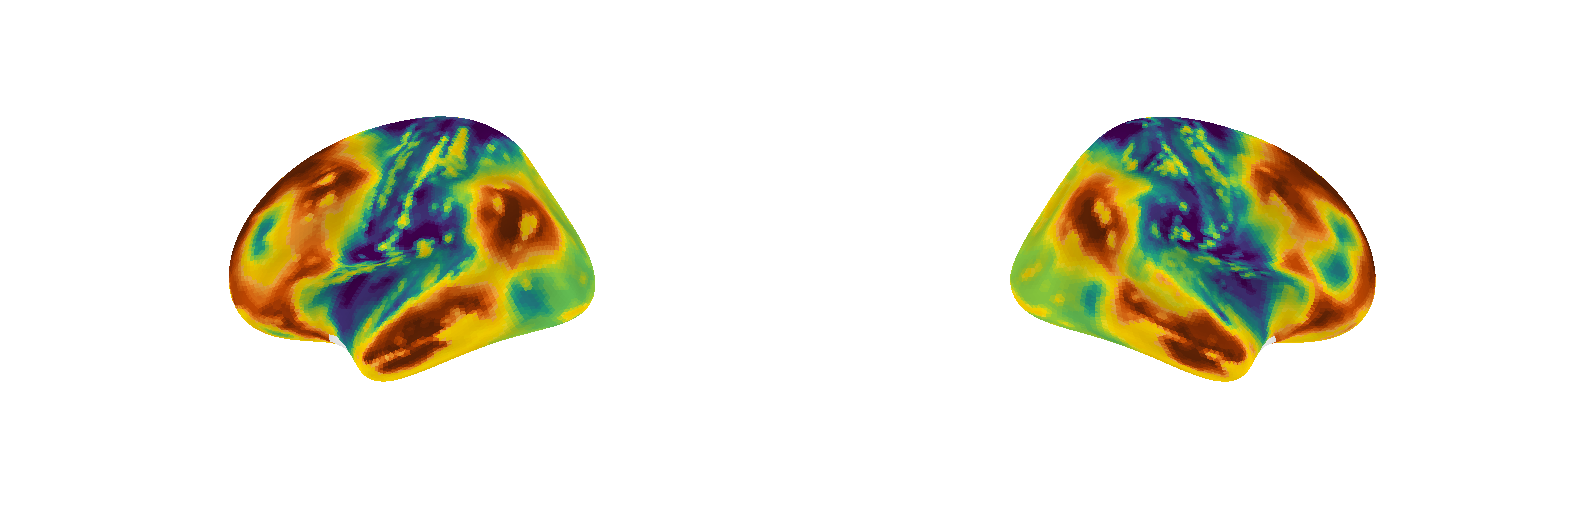

In [13]:
my_min = a.min()
my_max = a.max()

figure = plot_surf_infl(fs5, 
                        fsize=(28,9),
                        surf_map_l = a, 
                        surf_map_r = b,
                        vmin = my_min,
                        vmax = my_max,
                        threshold = None,
                        alpha = 1.,
                        cmap = pnasEDITED,
                        mask_lh = cort_lh,
                        mask_rh = cort_rh)

# Gradient 2

In [14]:
vol_filename   = '/data/pt_mar006/components/mni3_component_2_reverse.nii.gz'

surfLH_fileout = '/data/pt_mar006/components/mni3_component_2_lh_rev.mgz' 
surfRH_fileout = '/data/pt_mar006/components/mni3_component_2_rh_rev.mgz'

#B_lh = map_to_surf(vol_filename, 'lh', surfLH_fileout)
#B_rh = map_to_surf(vol_filename, 'rh', surfRH_fileout)

B_lh = nb.load(surfLH_fileout).get_data().reshape(10242,)
B_rh = nb.load(surfRH_fileout).get_data().reshape(10242,)

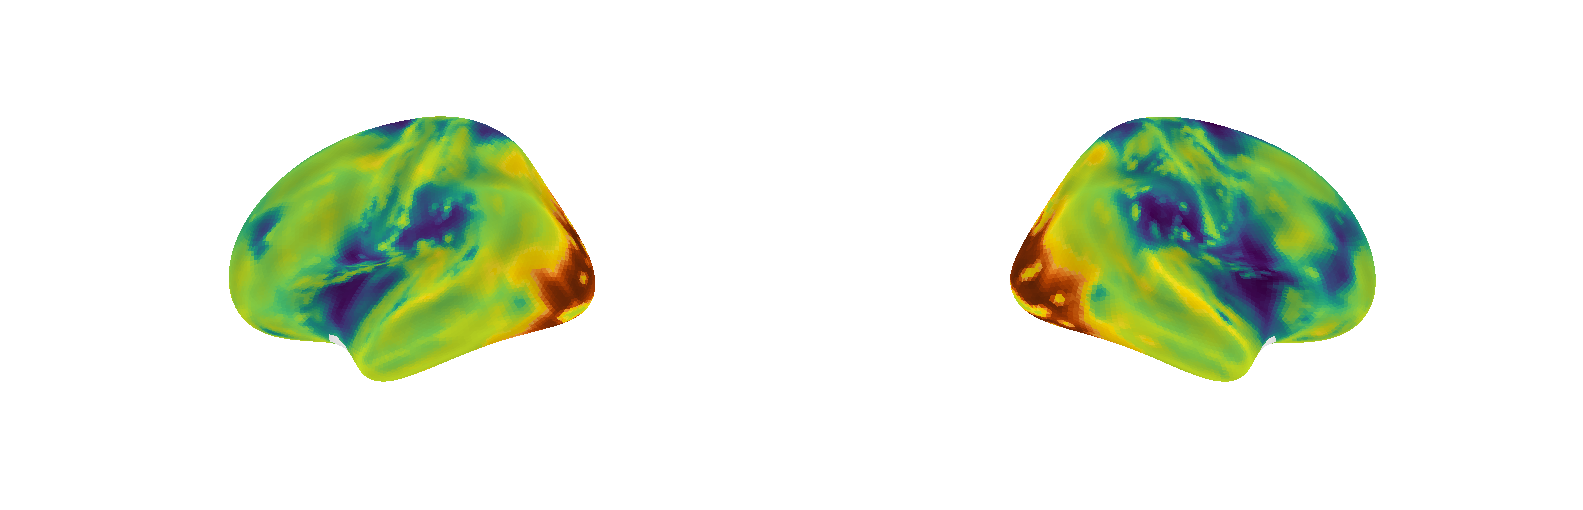

In [15]:
my_min = B_lh.min()
my_max = B_lh.max()

figure = plot_surf_infl(fs5, 
                        fsize=(28, 9),
                        surf_map_l = B_lh, 
                        surf_map_r = B_rh,
                        vmin = my_min,
                        vmax = my_max,
                        threshold = None,
                        alpha = 1.,
                        cmap = pnasEDITED,
                        mask_lh = cort_lh,
                        mask_rh = cort_rh)

# Gradient 2, five-percentiles

In [16]:
X = B_lh
Y = B_rh
print X.shape, Y.shape

(10242,) (10242,)


In [17]:
a     = X.copy()
b     = Y.copy()

bins         = 20
steps        = int((1/float(bins))*len(a))
# from lowest to highest
data_argsort = np.argsort(a)[::-1]
data_argsort = np.flip(data_argsort, axis=0)

data_argsort_b = np.argsort(b)[::-1]
data_argsort_b = np.flip(data_argsort_b, axis=0)


for thisp in range(bins):
    # from highest to lowest
    index = data_argsort[thisp*steps :(thisp+1)*steps+1] 
    a[index] = thisp
    
    index_b = data_argsort_b[thisp*steps :(thisp+1)*steps+1]
    b[index_b] = thisp    


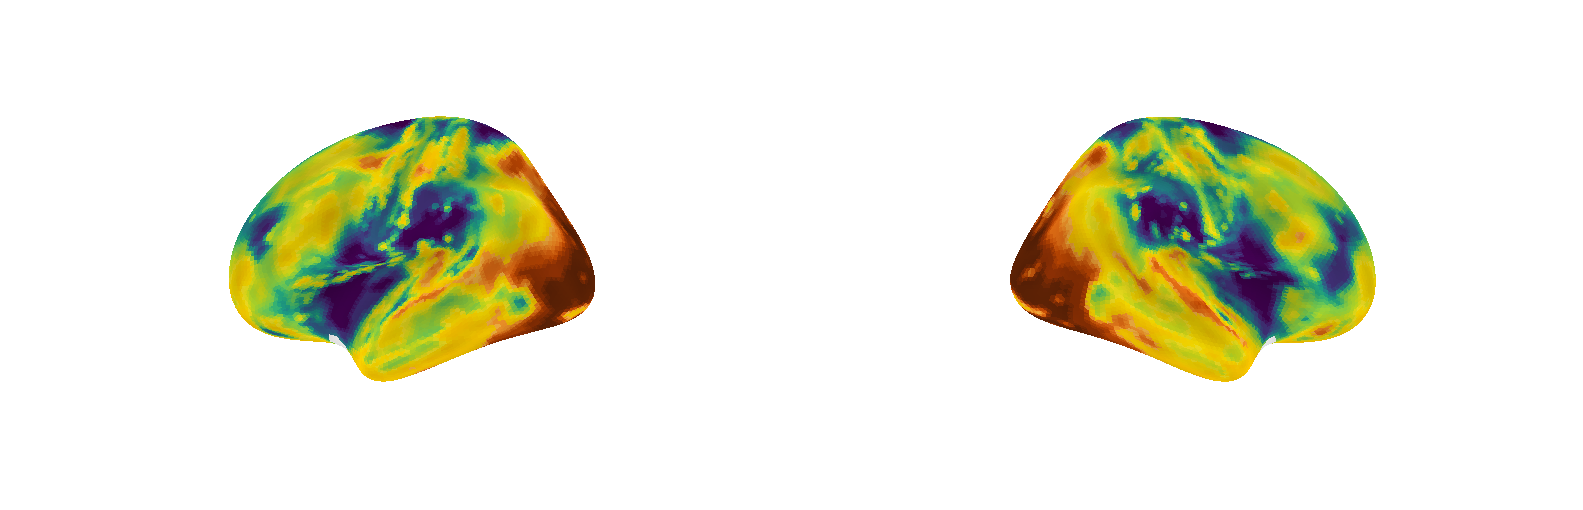

In [18]:
my_min = a.min()
my_max = a.max()

figure = plot_surf_infl(fs5, 
                        fsize=(28,9),
                        surf_map_l = a, 
                        surf_map_r = b,
                        vmin = my_min,
                        vmax = my_max,
                        threshold = None,
                        alpha = 1.,
                        cmap = pnasEDITED,
                        mask_lh = cort_lh,
                        mask_rh = cort_rh)

# Gradient 3

In [19]:
vol_filename = '/data/pt_mar006/components/mni3_component_3.nii.gz'

surfLH_fileout = '/data/pt_mar006/components/mni3_component_3_lh.mgz' 
surfRH_fileout = '/data/pt_mar006/components/mni3_component_3_rh.mgz'

#C_lh = map_to_surf(vol_filename, 'lh', surfLH_fileout)
#C_rh = map_to_surf(vol_filename, 'rh', surfRH_fileout)

C_lh = nb.load(surfLH_fileout).get_data().reshape(10242,)
C_rh = nb.load(surfRH_fileout).get_data().reshape(10242,)


In [20]:
-C_lh.min(), -C_lh.max()

(2.6302226, -0.93085134)

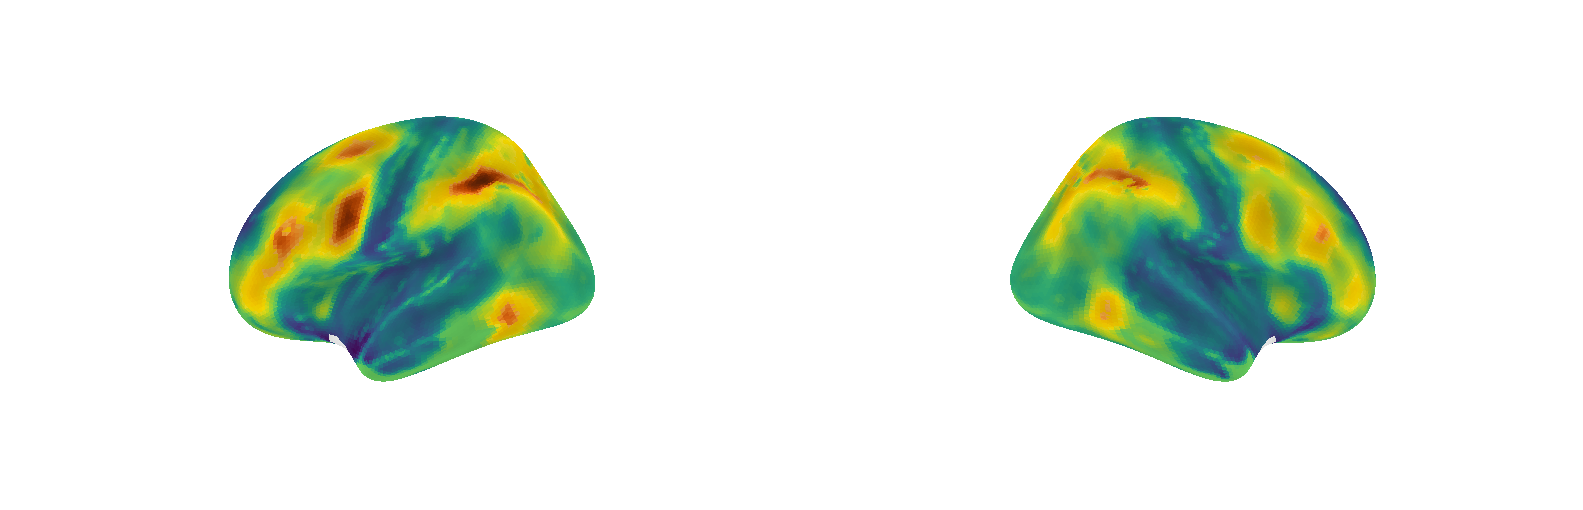

In [21]:
my_min = -C_lh.max()
my_max = -C_lh.min()

figure = plot_surf_infl(fs5, 
                        fsize=(28,9),
                        surf_map_l = -C_lh, 
                        surf_map_r = -C_rh,
                        vmin = my_min,
                        vmax = my_max,
                        threshold = None,
                        alpha = 1.,
                        cmap = pnasEDITED,
                        mask_lh = cort_lh,
                        mask_rh = cort_rh)


# Gradient 3, five-percentiles

In [22]:
X = -C_lh
Y = -C_rh
print X.shape, Y.shape

(10242,) (10242,)


In [23]:
a     = X.copy()
b     = Y.copy()


bins         = 20
steps        = int((1/float(bins))*len(a))
# from lowest to highest
data_argsort = np.argsort(a)[::-1]
data_argsort = np.flip(data_argsort, axis=0)

data_argsort_b = np.argsort(b)[::-1]
data_argsort_b = np.flip(data_argsort_b, axis=0)


for thisp in range(bins):
    # from highest to lowest
    index = data_argsort[thisp*steps :(thisp+1)*steps+1] 
    bmin = a[index].min()
    bmax = a[index].max()

    a[index] = thisp
    
    index_b = data_argsort_b[thisp*steps :(thisp+1)*steps+1]
    b[index_b] = thisp    
    

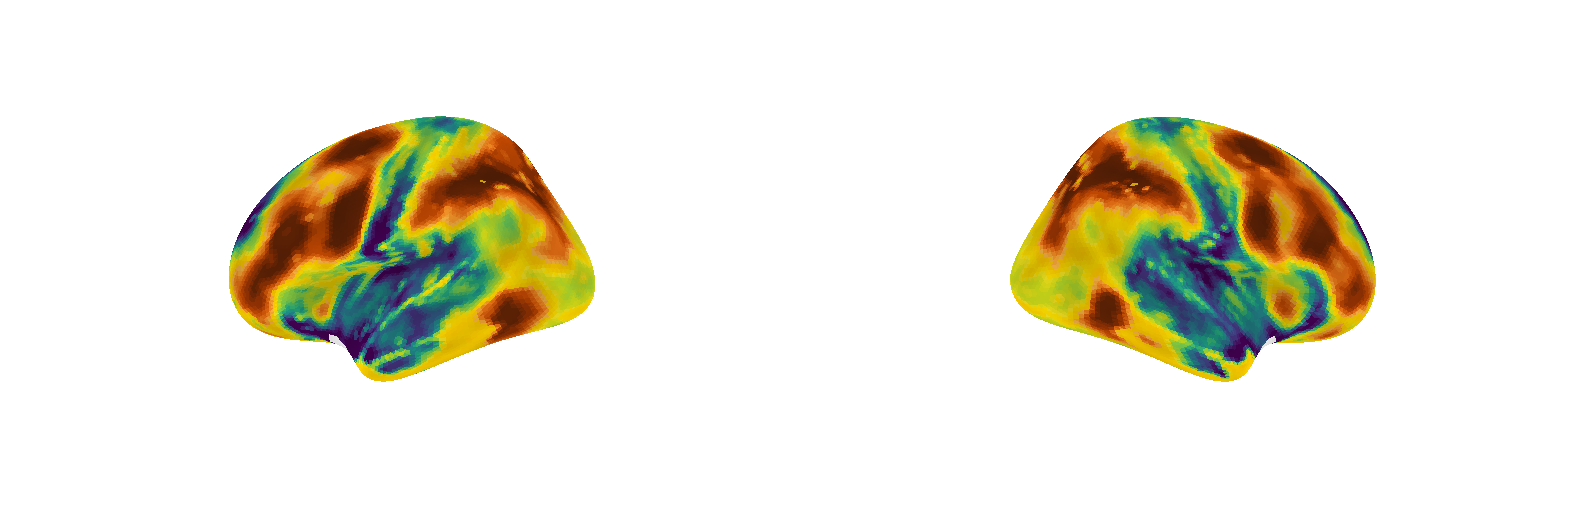

In [24]:
my_min = a.min()
my_max = a.max()

figure = plot_surf_infl(fs5, 
                        fsize=(28,9),
                        surf_map_l = a, 
                        surf_map_r = b,
                        vmin = my_min,
                        vmax = my_max,
                        threshold = a.min(),
                        alpha = 1.,
                        cmap = pnasEDITED,
                        mask_lh = cort_lh,
                        mask_rh = cort_rh)


# Connectivity Space

In [25]:
comp_file_01 = '/data/pt_mar006/subjects_group/mni3_component_1.nii.gz'
comp_file_02 = '/data/pt_mar006/subjects_group/mni3_component_2.nii.gz'
comp_file_03 = '/data/pt_mar006/subjects_group/mni3_component_3.nii.gz'

image_mask = os.path.join('/data/pt_mar006/subjects_group',
                          'mni3_rest_gm_mask.nii.gz')

gm_mask = nb.load(image_mask).get_data()
x    = np.where(gm_mask==1)[0]
y    = np.where(gm_mask==1)[1]
z    = np.where(gm_mask==1)[2]

comp_01     = np.array(nb.load(comp_file_01).get_data())
comp_02     = np.array(nb.load(comp_file_02).get_data())
comp_03     = np.array(nb.load(comp_file_03).get_data())

cmp_01_array = comp_01[x,y,z]
cmp_02_array = comp_02[x,y,z]
cmp_03_array = comp_03[x,y,z]

In [26]:
df = pd.DataFrame(columns=['e1', 'e2', 'e3'])

df['e1'] = cmp_01_array
df['e2'] = cmp_02_array 
df['e3'] = cmp_03_array 

In [27]:
import matplotlib.cm as cm

norm_1 = mpl.colors.Normalize(vmin=df['e1'].min(), vmax=df['e1'].max())
cmap_1 = cm.Reds
map_1  = cm.ScalarMappable(norm=norm_1, cmap=cmap_1)

norm_2 = mpl.colors.Normalize(vmin=df['e2'].min(), vmax=df['e2'].max())
cmap_2 = cm.Greens
map_2  = cm.ScalarMappable(norm=norm_2, cmap=cmap_2)

norm_3 = mpl.colors.Normalize(vmin=df['e3'].max(), vmax=df['e3'].min() )
cmap_3 = cm.Blues
map_3  = cm.ScalarMappable(norm=norm_3, cmap=cmap_3)

In [28]:
c = np.ones(map_1.to_rgba(df['e1']).shape)

a = df['e2'].copy()
a = a - a.min() 
a = a / a.max()
c[:,1] = a

a = df['e3'].copy()
a = a - a.min() 
a = a / a.max()
c[:,2] = a

a = df['e1'].copy()
a = a - a.min() 
a = a / a.max()
c[:,0] = a
c[:,1] = c[:,1] * ((a - 1) * -1)
c[:,2] = c[:,2] * ((a - 1) * -1)

In [29]:
c.shape

(33327, 4)

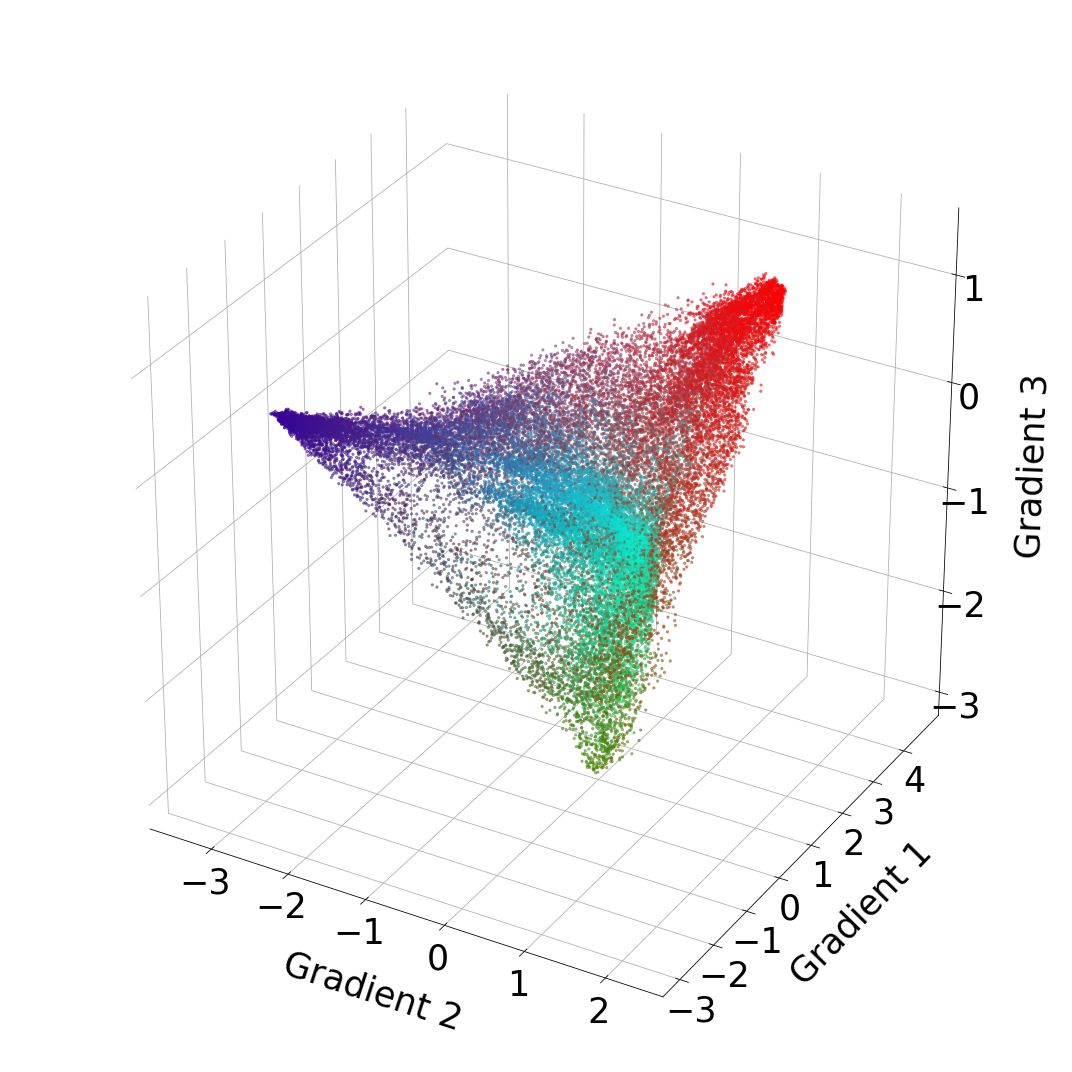

In [30]:
import matplotlib
matplotlib.use("TKAGG")
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

figure = plt.figure(figsize=(15,15), facecolor='w')
ax     = figure.gca(projection='3d')

ax.patch.set_facecolor('white')
#ax.grid(False)

ax.scatter(df['e2'], df['e1'], df['e3'], 
           c = c,
           s = 20,
           alpha = 0.5,
           marker = '.',
           )

ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_ylim([np.min(df['e1']) - 0.5, np.max(df['e1']) + 0.5]) 
ax.set_xlim([np.min(df['e2']) - 0.5, np.max(df['e2']) + 0.5])
ax.set_zlim([np.min(df['e3']) - 0.5, np.max(df['e3']) + 0.5])

yLabel = ax.set_ylabel('\nGradient 1', linespacing=3.1, fontsize=35)
xLabel = ax.set_xlabel('\nGradient 2', linespacing=3.2, fontsize=35)
zLabel = ax.set_zlabel('\nGradient 3', linespacing=3.4, fontsize=35)

ax.dist = 10
plt.tick_params(labelsize=35)
plt.tight_layout()



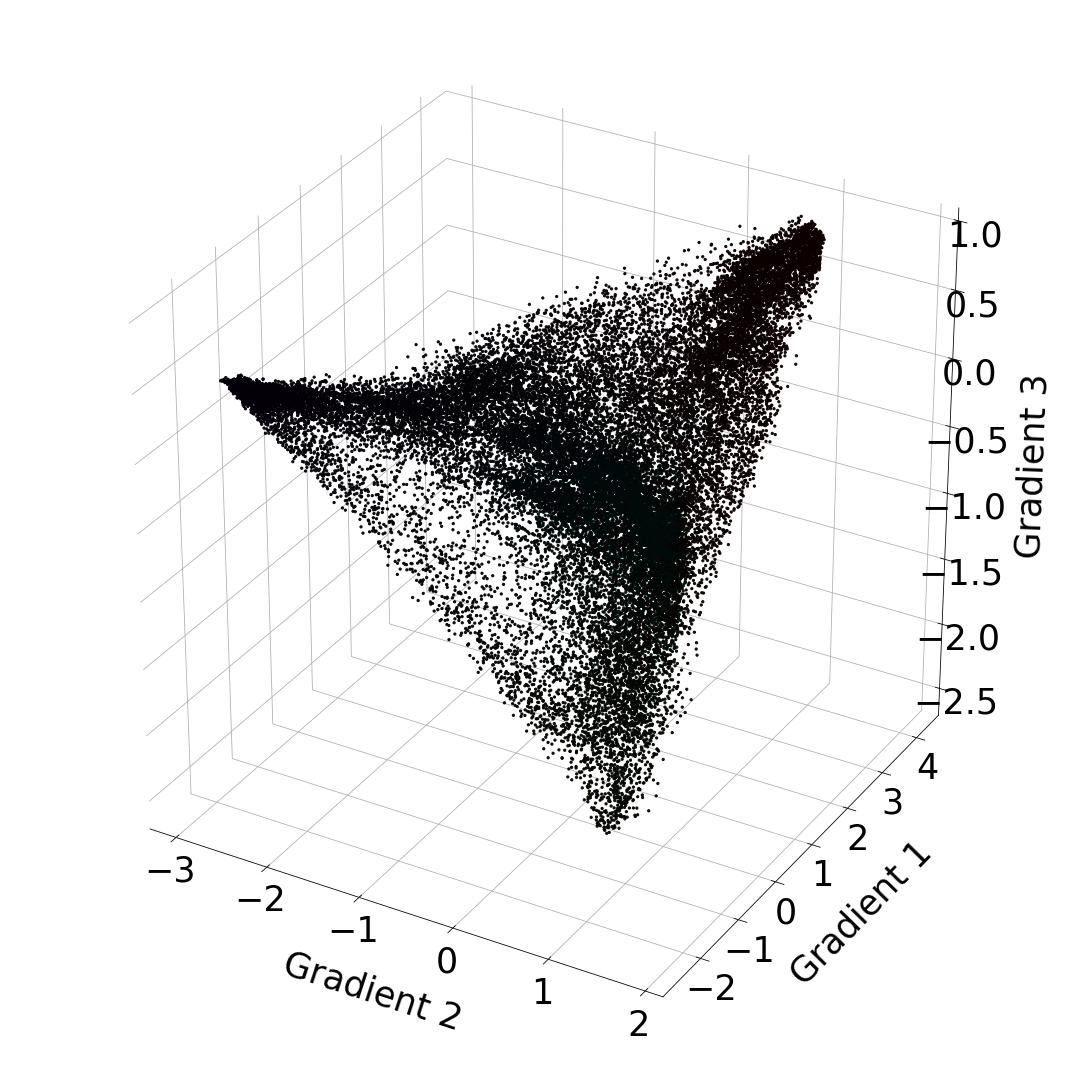

In [31]:
figure = plt.figure(figsize=(15,15), facecolor='w')
ax     = figure.gca(projection='3d')

ax.patch.set_facecolor('white')
#ax.grid(False)

ax.scatter(df['e2'], df['e1'], df['e3'], 
           c = c*0.05,
           s = 20,
           alpha = 0.95,
           marker = '.',
           )

ax.set_ylim([np.min(df['e1']), np.max(df['e1'])]) 
ax.set_xlim([np.min(df['e2']), np.max(df['e2'])])
ax.set_zlim([np.min(df['e3']), np.max(df['e3'])])

yLabel = ax.set_ylabel('\nGradient 1', linespacing=3.1, fontsize=35)
xLabel = ax.set_xlabel('\nGradient 2', linespacing=3.2, fontsize=35)
zLabel = ax.set_zlabel('\nGradient 3', linespacing=3.4, fontsize=35)

ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


ax.dist = 10
plt.tick_params(labelsize=35)
plt.tight_layout()

## Connectivity space projected on surface

In [32]:
import matplotlib.cm as cm
import matplotlib as mpl

norm_1 = mpl.colors.Normalize(vmin=A_lh.min(), vmax=A_lh.max())
cmap_1 = cm.Reds
map_1  = cm.ScalarMappable(norm=norm_1, cmap=cmap_1)

norm_2 = mpl.colors.Normalize(vmin=B_lh.min(), vmax=B_lh.max())
cmap_2 = cm.Greens
map_2  = cm.ScalarMappable(norm=norm_2, cmap=cmap_2)

norm_3 = mpl.colors.Normalize(vmin=C_lh.max(), vmax=C_lh.min() )
cmap_3 = cm.Blues
map_3  = cm.ScalarMappable(norm=norm_3, cmap=cmap_3)


In [33]:
c = np.ones((map_1.to_rgba(A_lh).shape[0], 3))
c[:,0] = A_lh.copy()
c[:,1] = -B_lh.copy()
c[:,2] = -C_lh.copy()

cmin = c.squeeze().min()
cmax = c.squeeze().max()

c = (c - cmin) / (cmax - cmin)

a = c[:,0]
c[:,1] = c[:,1] * ((a - 1) * -1)
c[:,2] = c[:,2] * ((a - 1) * -1)

d = np.ones(map_1.to_rgba(A_lh).shape) 
d[:, 0:3] = c


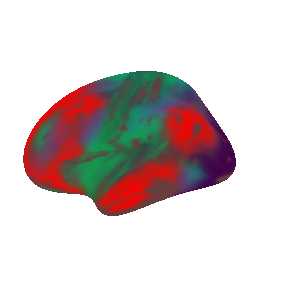

In [34]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

alpha = 1
limits = [-100, 50]

fig = plt.figure(figsize=(5,5), facecolor='w')
ax1 = fig.gca(projection='3d', xlim=limits, ylim=limits)

ax1.grid(False)
ax1.set_axis_off()
ax1.w_zaxis.line.set_lw(0.)
ax1.set_zticks([])
ax1.view_init(elev=0, azim=180)

coords = coords_left
faces  = faces_left

p3dcollec = ax1.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2],
                            triangles=faces, linewidth=0.,
                            antialiased=False,
                            color='white')

ax1.view_init(elev=0, azim=180)

bg_map  = fs5['sulc_left']
bg_data = load_surf_data(bg_map)
bg_faces = np.mean(bg_data[faces_left], axis=1)

bg_faces = bg_faces - bg_faces.min()
bg_faces = bg_faces / bg_faces.max() / 2.

darkness = 0.1
bg_faces *= darkness

face_colors = plt.cm.gray_r(bg_faces)
face_colors = np.mean(d[faces_left], axis=1) * face_colors

p3dcollec.set_facecolors(face_colors)


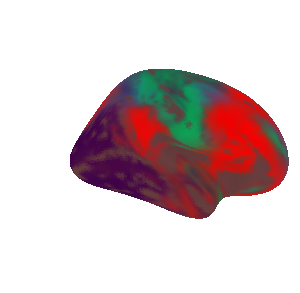

In [35]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

alpha = 1
limits = [-100, 50]

fig = plt.figure(figsize=(5,5), facecolor='w')
ax1 = fig.gca(projection='3d', xlim=limits, ylim=limits)

ax1.grid(False)
ax1.set_axis_off()
ax1.w_zaxis.line.set_lw(0.)
ax1.set_zticks([])
ax1.view_init(elev=0, azim=0)

coords = coords_right
faces  = faces_right

p3dcollec = ax1.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2],
                            triangles=faces, linewidth=0.,
                            antialiased=False,
                            color='white')
bg_map  = fs5['sulc_right']
bg_data = load_surf_data(bg_map)
bg_faces = np.mean(bg_data[faces_right], axis=1)

bg_faces = bg_faces - bg_faces.min()
bg_faces = bg_faces / bg_faces.max() / 2.

darkness = 0.15
bg_faces *= darkness

face_colors = plt.cm.gray_r(bg_faces)
face_colors = np.mean(d[faces_right], axis=1) * face_colors

p3dcollec.set_facecolors(face_colors)